# View New test results

Loaded rows: 5 from folder 'molhiv_results_approx_no_prox'


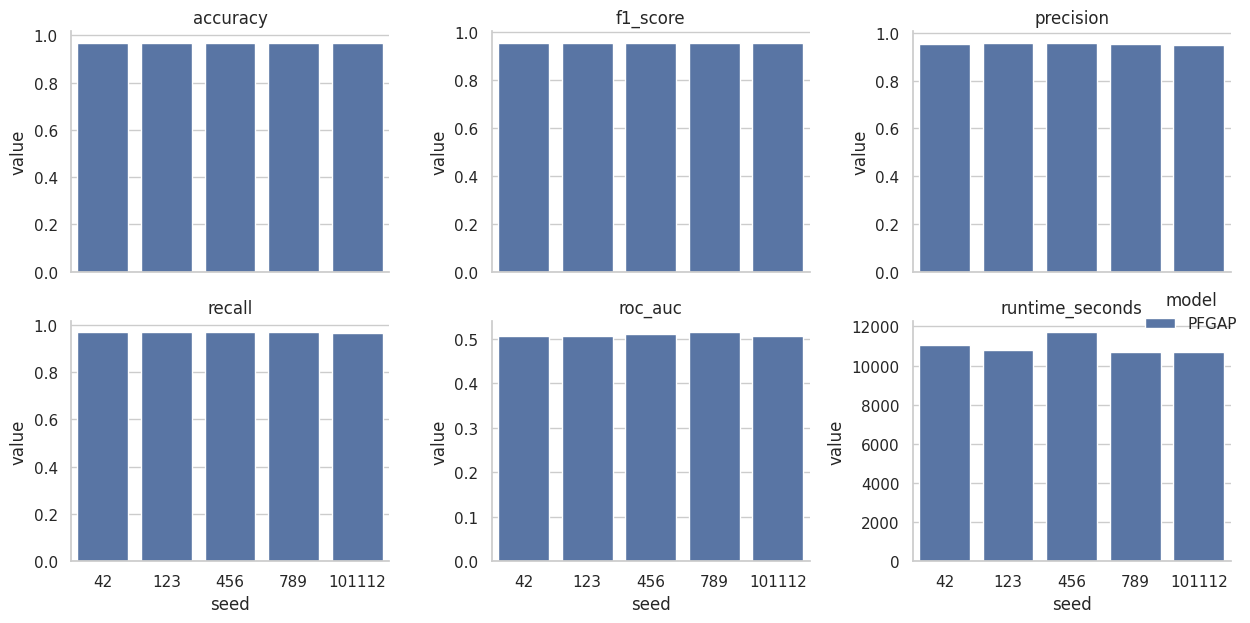

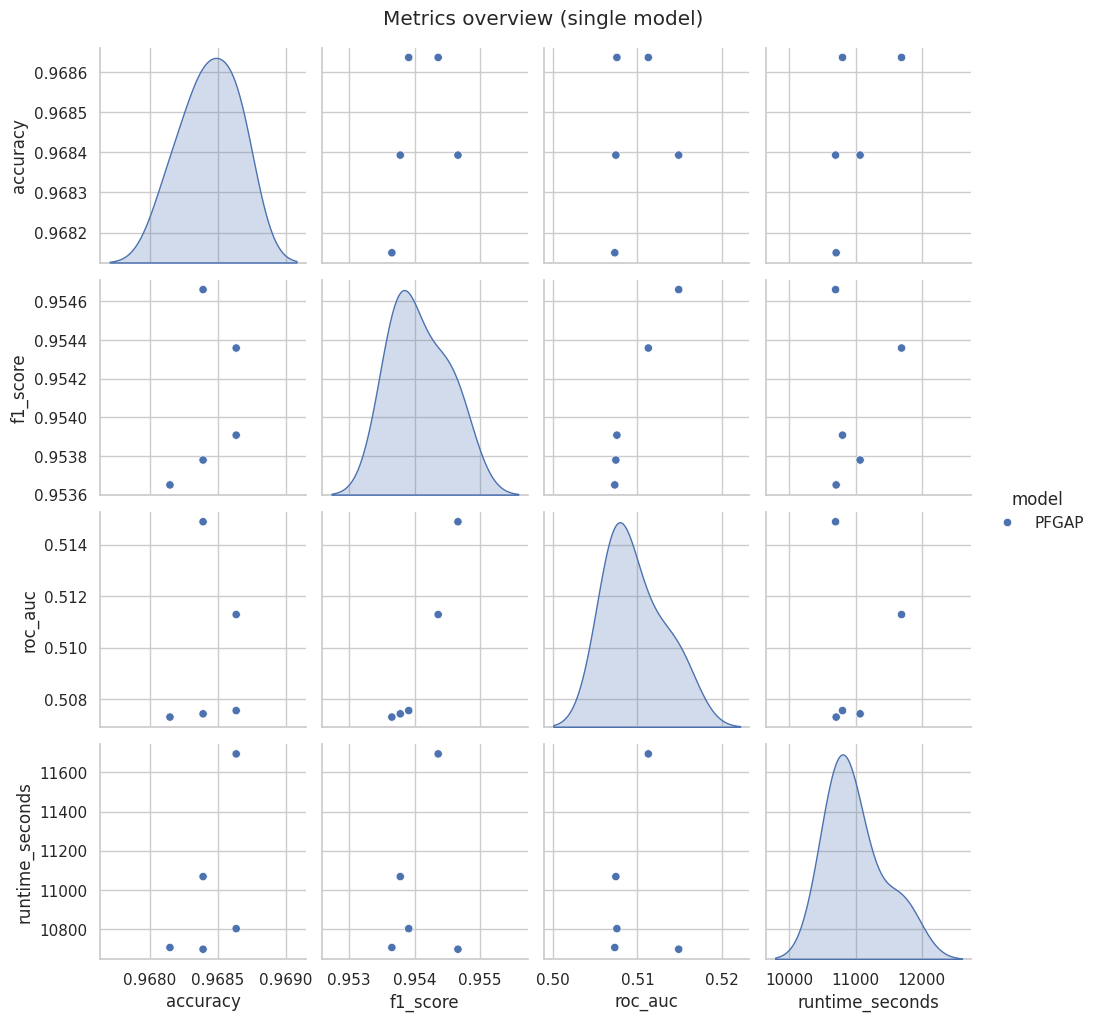

In [ ]:
from pathlib import Path
import json
from typing import List, Dict, Any, Optional

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


try:
    BASE_RESULTS_DIR = Path(__file__).resolve().parent  # data/user_distances_with_dependencies
except NameError:
    # __file__ is not defined in notebooks; fall back to current working directory
    BASE_RESULTS_DIR = Path.cwd()


def _extract_metrics(model_name: str, seed: int, model_payload: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    """Extract a flat metrics dict from a model payload if it contains results.

    Expects keys like accuracy, f1_score, precision, recall, roc_auc, runtime_seconds, confusion_matrix.
    Returns None if payload is empty.
    """
    if not model_payload:
        return None

    # Some fields are optional; use .get
    metrics: Dict[str, Any] = {
        "seed": seed,
        "model": model_name,
        "distance_metric": model_payload.get("distance_metric"),
        "accuracy": model_payload.get("accuracy"),
        "f1_score": model_payload.get("f1_score"),
        "precision": model_payload.get("precision"),
        "recall": model_payload.get("recall"),
        "roc_auc": model_payload.get("roc_auc"),
        "runtime_seconds": model_payload.get("runtime_seconds"),
        "memory_usage_mb": model_payload.get("memory_usage_mb"),
    }

    # Try to unpack confusion matrix if present; assume format [[tn, fp], [fn, tp]]
    cm = model_payload.get("confusion_matrix")
    if isinstance(cm, list) and len(cm) == 2 and all(isinstance(row, list) and len(row) == 2 for row in cm):
        tn, fp = cm[0]
        fn, tp = cm[1]
        metrics.update({
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp,
        })

    return metrics


def load_results_folder(folder_name: str) -> pd.DataFrame:
    """Load all `{seed}_comprehensive_results.json` files from a folder under this directory.

    Example: folder_name="molhiv_results_approx_no_prox"
    Returns a tidy DataFrame with one row per (seed, model) containing key metrics.
    """
    folder_path = BASE_RESULTS_DIR / folder_name
    if not folder_path.exists():
        raise FileNotFoundError(f"Results folder not found: {folder_path}")

    rows: List[Dict[str, Any]] = []
    for json_path in sorted(folder_path.glob("*_comprehensive_results.json")):
        try:
            with open(json_path, "r") as f:
                payload = json.load(f)
        except Exception as e:
            print(f"Failed to read {json_path}: {e}")
            continue

        seed = payload.get("seed")
        for model_key, model_name in [("knn_results", "KNN"), ("pfgap_results", "PFGAP")]:
            metrics = _extract_metrics(model_name, seed, payload.get(model_key, {}))
            if metrics is not None:
                rows.append(metrics)

    if not rows:
        return pd.DataFrame(columns=[
            "seed", "model", "distance_metric", "accuracy", "f1_score", "precision", "recall",
            "roc_auc", "runtime_seconds", "memory_usage_mb", "tn", "fp", "fn", "tp"
        ])

    df = pd.DataFrame(rows)

    # Sort for readability
    sort_cols = [c for c in ["seed", "model"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)

    return df


# Example usage: adjust folder below to your target
folder_to_load = "molhiv_results_approx_no_prox"  # e.g., "molhiv_results"
results_df = load_results_folder(folder_to_load)
print(f"Loaded rows: {len(results_df)} from folder '{folder_to_load}'")
results_df.head()


# -------------------- Plots --------------------
# The following plots will compare models when both are present. If only one model exists, they degrade gracefully.

sns.set_theme(style="whitegrid")

if results_df.empty:
    print("No results found to plot.")
else:
    # Basic long-form comparisons
    metrics_to_compare = [
        "accuracy", "f1_score", "precision", "recall", "roc_auc", "runtime_seconds"
    ]

    # 1) Per-seed grouped bar for key metrics
    melted = results_df.melt(
        id_vars=["seed", "model"], value_vars=[m for m in metrics_to_compare if m in results_df.columns],
        var_name="metric", value_name="value"
    )

    # Only plot non-null values
    melted = melted.dropna(subset=["value"]).copy()

    if not melted.empty:
        g = sns.catplot(
            data=melted, kind="bar", x="seed", y="value", hue="model", col="metric",
            col_wrap=3, height=3.2, aspect=1.2, sharey=False
        )
        g.set_titles("{col_name}")
        for ax in g.axes.flatten():
            ax.set_xlabel("seed")
            ax.set_ylabel("value")
        plt.tight_layout()
        plt.show()
    else:
        print("No comparable metric values found for grouped bar charts.")

    # 2) Scatter: compare metrics across models, highlighting points by model
    if results_df["model"].nunique() > 1:
        # Pivot to align KNN vs PFGAP by seed
        pivot_frames = {}
        for metric in [m for m in ["accuracy", "f1_score", "roc_auc"] if m in results_df.columns]:
            pivot = results_df.pivot_table(index="seed", columns="model", values=metric)
            # Only keep rows where both models present
            pivot = pivot.dropna(subset=[col for col in ["KNN", "PFGAP"] if col in pivot.columns])
            if not pivot.empty and set(["KNN", "PFGAP"]).issubset(pivot.columns):
                pivot_frames[metric] = pivot

        # Lollipop/Difference plots per metric
        for metric, pivot in pivot_frames.items():
            diff = (pivot["PFGAP"] - pivot["KNN"]).rename("delta")
            order = diff.sort_values().index

            fig, ax = plt.subplots(figsize=(6, max(2.5, 0.35 * len(order))))
            y = np.arange(len(order))
            ax.hlines(y, pivot.loc[order, "KNN"], pivot.loc[order, "PFGAP"], color="#9aa0a6")
            ax.plot(pivot.loc[order, "KNN"], y, "o", label="KNN", color="#1f77b4")
            ax.plot(pivot.loc[order, "PFGAP"], y, "o", label="PFGAP", color="#d62728")
            ax.axvline(0.0 if metric == "roc_auc" else None, color="#e0e0e0")
            ax.set_yticks(y)
            ax.set_yticklabels([str(s) for s in order])
            ax.set_xlabel(metric)
            ax.set_ylabel("seed")
            ax.set_title(f"{metric}: PFGAP vs KNN (lollipop)")
            ax.legend()
            plt.tight_layout()
            plt.show()

        # Delta barplot summary per metric
        if pivot_frames:
            delta_rows = []
            for metric, pivot in pivot_frames.items():
                for seed_val, row in pivot.iterrows():
                    delta_rows.append({
                        "seed": seed_val,
                        "metric": metric,
                        "delta": row["PFGAP"] - row["KNN"],
                    })
            delta_df = pd.DataFrame(delta_rows)

            fig, ax = plt.subplots(figsize=(7.5, 4))
            sns.boxplot(data=delta_df, x="metric", y="delta", ax=ax, color="#aec7e8")
            sns.stripplot(data=delta_df, x="metric", y="delta", ax=ax, color="#d62728", jitter=0.15, alpha=0.7)
            ax.axhline(0.0, color="#444", linewidth=1, linestyle="--")
            ax.set_title("PFGAP - KNN performance deltas by metric")
            plt.tight_layout()
            plt.show()
        else:
            print("KNN and PFGAP not both present for comparable seeds; skipping difference plots.")
    else:
        # Single-model visuals
        # Runtime distribution and metric histograms
        available_metrics = [m for m in ["accuracy", "f1_score", "roc_auc", "runtime_seconds"] if m in results_df.columns]
        if available_metrics:
            g = sns.pairplot(results_df, vars=available_metrics, hue="model")
            plt.suptitle("Metrics overview (single model)", y=1.02)
            plt.show()

    # 3) Confusion matrix components (if present)
    cm_cols = [c for c in ["tn", "fp", "fn", "tp"] if c in results_df.columns]
    if cm_cols:
        cm_melt = results_df.melt(id_vars=["seed", "model"], value_vars=cm_cols, var_name="cm_component", value_name="count")
        g = sns.catplot(data=cm_melt, kind="bar", x="cm_component", y="count", hue="model", col="seed", col_wrap=4, height=3, sharey=False)
        g.set_titles("seed={col_name}")
        plt.tight_layout()
        plt.show()


In [ ]:
results_df.head

,seed,model,distance_metric,accuracy,f1_score,precision,recall,roc_auc,runtime_seconds,memory_usage_mb
0,42,KNN,None,None,None,None,None,None,None,None
1,123,KNN,None,None,None,None,None,None,None,None
2,456,KNN,None,None,None,None,None,None,None,None
3,789,KNN,None,None,None,None,None,None,None,None
4,101112,KNN,None,None,None,None,None,None,None,None


In [ ]:
results_df["runtime_seconds"].mean() /60

183.2272535308202